# 서울시 공원 지도에 표시하기
서울시 주요 공원현황 데이터에, 카카오api에서 위도, 경도 데이터를 가져와 지도에 표시한다.

이때, 각 공원의 면적을 크기에 따라 3그룹으로 나누어 크기를 대중소로 나타내어 표시한다.

In [1]:
import folium
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

## 데이터 파악하고 정리하기

In [3]:
park = pd.read_csv('서울시 주요 공원현황(수정).csv')
park.head(2)

,공원번호,공원명,공원개요,면적,개원일,주요시설,주요식물,안내도,오시는길,이용시참고사항,이미지,지역,공원주소,관리부서,전화번호,X좌표(GRS80TM),Y좌표(GRS80TM),X좌표(WGS84),Y좌표(WGS84),바로가기
0,1,남산도시자연공원,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,2896887㎡ 2454140㎡ 442747㎡,1968.9.10,기반시설 : 광장 45950㎡ 도로 108530㎡ 산책로 6.7㎞ (북측:3.7㎞/...,소나무 단풍 아카시아 상수리나무 등 191종 2881870주,http://parks.seoul.go.kr/upload/seditorMulti/2...,명동역(남산케이블카 와룡묘 서울애니메이션센터 방면) 도보 명동역 3번출구 → 퍼시픽...,남산공원 차량통행 금지안내 2005년 5월 1일부터 남산공원에 일반승용차 택시 통행...,http://parks.seoul.go.kr/file/info/view.do?fId...,중구,서울특별시 중구 삼일대로 231(예장동),서울특별시중부푸른도시사업소,02-3783-5900,198364.107,450395.554,126.990377,37.550140,http://parks.seoul.go.kr/template/sub/namsan.do
1,3,길동생태공원,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,80683㎡,1999.5.20,탐방객안내소 야외전시대 관찰대 목재데크 조류관찰대 길동생태문화센터,소나무 보리수 등 64종 31800주 산국 부들 등 138종 192800본,http://parks.seoul.go.kr/template/common/img/p...,NaN,매주 월요일은 휴관입니다 사전예약 후 입장하실 수 있습니다. ▶ 인터넷 예약 바로가...,http://parks.seoul.go.kr/file/info/view.do?fId...,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),동부공원녹지사업소 길동생태공원,02-489-2770,213554.120,448852.675,127.154779,37.540394,http://parks.seoul.go.kr/template/sub/gildong.do


In [4]:
# null값이 있는 칼럼명을 확인 
park.isnull().sum()

공원번호              0
공원명               0
공원개요              1
면적                3
개원일              10
주요시설              8
주요식물             44
안내도              30
오시는길             17
이용시참고사항          12
이미지               0
지역                0
공원주소              0
관리부서              0
전화번호              0
X좌표(GRS80TM)     10
Y좌표(GRS80TM)     10
X좌표(WGS84)        1
Y좌표(WGS84)        1
바로가기            114
dtype: int64

In [5]:
# 면적에 na 값이 있다면 으로 대체함
park['면적'] = park.면적.fillna('0')
park.면적.isnull().sum()

0

In [6]:
def calc_area(s):
    if s == '0':
        return 0
#면적칼럼의 숫자만 남기기 위해
    num_list = s.strip().split('㎡') 
    area = 0
    for num_str in num_list:
        if num_str == '':
            continue
        area += float(num_str)

    return area

In [7]:
park['area'] = park.면적.map(calc_area).astype(int)
park[['면적','area']].head()

,면적,area
0,2896887㎡ 2454140㎡ 442747㎡,5793774
1,80683㎡,80683
2,9132690㎡,9132690
3,480994㎡,480994
4,2284085㎡,2284085


In [8]:
park_new = park[['공원명','지역','공원주소','area','공원개요']]
park_new.head()

,공원명,지역,공원주소,area,공원개요
0,남산도시자연공원,중구,서울특별시 중구 삼일대로 231(예장동),5793774,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...
1,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),80683,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...
2,서울대공원,과천시,경기도 과천시 대공원광장로 102,9132690,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...
3,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),480994,당초 골프장 승마장 등이 있던 뚝섬일대를 주거업무 지역으로 개발할 경우 약 4조원에...
4,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),2284085,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...


 ## 위도, 경도 정보 구하기

In [9]:
import requests
from urllib.parse import quote

In [10]:
with open('kakaoapikey.txt', mode='r') as key_file:
    kakao_key = key_file.read()
local_url = 'https://dapi.kakao.com/v2/local/search/address.json'

In [11]:
lat_list, lng_list = [], []
for i in park_new.index:
    try:
        url = f"{local_url}?query={quote(park_new['공원주소'][i])}"
        result = requests.get(url,
                headers={"Authorization": "KakaoAK "+kakao_key}).json()
        lat = float(result['documents'][0]['y'])
        lng = float(result['documents'][0]['x'])
        lat_list.append(lat)
        lng_list.append(lng)
    except:
        print(park_new.공원명[i], park_new.공원주소[i])
# 우편번호 들어가서 수집을 하지 못했음

낙산근린공원 서울특별시 종로구 낙산길 41 (우) 03085
자매근린공원 서울특별시 영등포구 의사당대로 166 (우) 07324
와룡근린공원 서울특별시 종로구 와룡공원길 192 (우) 03063
삼청근린공원 서울특별시 종로구 북촌로 134-1 (우) 03050
세종로공원 서울특별시 종로구 세종대로 189 (우) 03172


In [12]:
lat_list, lng_list = [], []
for i in park_new.index:
    try:
        addr = park_new.공원주소[i].split('(우)')[0] # (우) 뒷부분 제거
        url = f"{local_url}?query={quote(addr)}"
        result = requests.get(url,
                headers={"Authorization": "KakaoAK "+kakao_key}).json()
        lat = float(result['documents'][0]['y'])
        lng = float(result['documents'][0]['x'])
        lat_list.append(lat)
        lng_list.append(lng)
    except:
        print(park_new.공원명[i], park_new.공원주소[i])

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
park_new['lat'], park_new['lng'] = lat_list, lng_list
park_new.head()

,공원명,지역,공원주소,area,공원개요,lat,lng
0,남산도시자연공원,중구,서울특별시 중구 삼일대로 231(예장동),5793774,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,37.555633,126.992218
1,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),80683,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,37.539066,127.153329
2,서울대공원,과천시,경기도 과천시 대공원광장로 102,9132690,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...,37.436431,127.014098
3,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),480994,당초 골프장 승마장 등이 있던 뚝섬일대를 주거업무 지역으로 개발할 경우 약 4조원에...,37.543070,127.041799
4,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),2284085,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...,37.572327,126.881889


## 면적을 3등분 하기

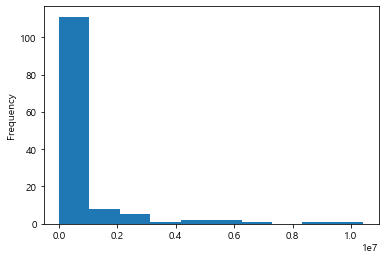

In [15]:
park_new.area.plot(kind='hist')
plt.show()

In [16]:
area_criteria = [-1, 100000, 1000000, 12000000]
labels = ['소형', '중형', '대형']
size_info = [3, 7, 15]

In [17]:
park_new['scale'] = pd.cut(park_new.area, area_criteria, labels=labels)
park_new['size'] = pd.cut(park_new.area, area_criteria, labels=size_info)
park_new.head()

,공원명,지역,공원주소,area,공원개요,lat,lng,scale,size
0,남산도시자연공원,중구,서울특별시 중구 삼일대로 231(예장동),5793774,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,37.555633,126.992218,대형,15
1,길동생태공원,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),80683,길동생태공원은 생물의 서식처를 제공하고 종다양성을 증진시키며 자연생태계의 생물들을 ...,37.539066,127.153329,소형,3
2,서울대공원,과천시,경기도 과천시 대공원광장로 102,9132690,서울대공원은 세계 각국의 야생동물들이 살아 숨 쉬는 서울동물원과 다양한 재미와 즐거...,37.436431,127.014098,대형,15
3,서울숲,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),480994,당초 골프장 승마장 등이 있던 뚝섬일대를 주거업무 지역으로 개발할 경우 약 4조원에...,37.543070,127.041799,중형,7
4,월드컵공원,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),2284085,월드컵공원은 서울의 서쪽에 위치하여 1978년부터 1993년까지 15년간 서울시민이...,37.572327,126.881889,대형,15


##  지도에 공원 표시하기

In [18]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)
for i in park_new.index:
    folium.CircleMarker(
        location=[park_new.lat[i], park_new.lng[i]], 
        radius=int(park_new['size'][i]),
        tooltip=f"{park_new.공원명[i]}({park_new.area[i]:,d}㎡)",
        color='#3186cc', fill_color='#3186cc'
    ).add_to(map)

title_html = '<h3 align="center" style="font-size:20px"><b>서울시내 공원 위치와 크기</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map

## 자치구별 공원 분석

In [19]:

park_gu = park_new.groupby('지역').sum()
park_gu['공원수'] = park_new.groupby('지역').count()['area']
del park_gu['lat']
del park_gu['lng']
park_gu.drop(['과천시'], inplace=True)
park_gu.rename(columns={'area': '공원면적'}, inplace=True)
park_gu.head()

,공원면적,공원수
지역,,
강남구,3626398,7
강동구,1526387,7
강북구,3714902,4
강서구,2194152,9
관악구,10431453,2


### 구별 공원면적

In [23]:
import json
geo_str = json.load(open('skorea_municipalities_geo_simple.json',
                         encoding='utf8'))

In [24]:
map = folium.Map(
        location=[37.5502, 126.982], 
        zoom_start=11, tiles='Stamen Toner'
)
map.choropleth(
    geo_data = geo_str,
    data = park_gu.공원면적,
    columns = [park_gu.index, park_gu.공원면적],
    fill_color = 'PuRd',
    key_on = 'feature.id'
)
for i in park_new.index:
    folium.CircleMarker(
        location=[park_new.lat[i], park_new.lng[i]], 
        radius=int(park_new['size'][i]),
        tooltip=f"{park_new.공원명[i]}({park_new.area[i]:,d}㎡)",
        color='green', fill_color='green'
    ).add_to(map)

title_html = '<h3 align="center" style="font-size:20px"><b>자치구별 공원면적</b></h3>'   
map.get_root().html.add_child(folium.Element(title_html))
map